In [1]:
# --- Setup base dir & env, then import deps (condensed) ---

# Stdlib
import os, sys
from pathlib import Path

def get_basedir(up: int = 2) -> Path:
    """Return dir `up` levels above running .py/.ipynb."""
    try:
        p = Path(__file__).resolve()        # .py
    except NameError:
        try:
            import ipynbname                # notebook
            p = Path(ipynbname.path()).resolve()
        except Exception:
            p = (Path.cwd() / "_dummy").resolve()    # fallback
    for _ in range(up): p = p.parent
    return p

# only initialize BASE_DIR once
BASE_DIR = globals().get("BASE_DIR")
if not isinstance(BASE_DIR, Path) or not BASE_DIR.exists():
    BASE_DIR = get_basedir()
    
sys.path[:0] = [
    str(BASE_DIR),
    str(BASE_DIR / "packages"),
    str(BASE_DIR / "packages" / "DiffBIR"),
    str(BASE_DIR / "packages" / "MST" / "simulation" / "train_code"),
]
os.chdir(BASE_DIR)
print(f"Set BASE = {BASE_DIR}")
os.environ.update({"CUDA_DEVICE_ORDER": "PCI_BUS_ID", "CUDA_VISIBLE_DEVICES": "1"})

# Third-party
import numpy as np, torch, scipy.io as scio, pytorch_lightning as pl
from argparse import ArgumentParser, Namespace 
from typing import Optional, Tuple, Set, List, Dict 
from torch import nn
from torch.nn import functional as F
from PIL import Image
from omegaconf import OmegaConf
from skimage.metrics import structural_similarity as ssim
from accelerate.utils import set_seed
from hyperopt import hp, fmin, tpe, Trials
import matplotlib.pyplot as plt

# Project
from packages.DiffBIR.utils.common import (
    instantiate_from_config, load_file_from_url, count_vram_usage,
    wavelet_decomposition, wavelet_reconstruction, wavelet_decomposition_msi,
)
from packages.DiffBIR.utils.inference import InferenceLoop
from packages.DiffBIR.utils.helpers import MSI_Pipeline
from packages.DiffBIR.utils.cond_fn import MeasMSEGuidance, Guidance
from packages.DiffBIR.model.gaussian_diffusion import Diffusion
from packages.DiffBIR.model.cldm import ControlLDM
from packages.MST.simulation.train_code.utils import *
from packages.MST.simulation.train_code.architecture import *


Set BASE = /home/newdisk/btsun/project/PSR-SCI


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1209 (you have 2.8.0+cu128)
    Python  3.12.11 (you have 3.9.19)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


use sdp attention as default
keep default attention mode
use sdp attention as default
keep default attention mode


In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=2):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.max_pool = nn.AdaptiveMaxPool2d((2, 2))

        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, 2, bias=False)

        self.SiLU = nn.SiLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.SiLU(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.SiLU(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class DoubleConvWoBN(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.double_conv(x) + self.res_conv(x)


class ChannelEncoder(nn.Module):
    def __init__(self):
        super(ChannelEncoder, self).__init__()
        self.conv1 = DoubleConvWoBN(in_channels=28, out_channels=21)
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear"),
            DoubleConvWoBN(in_channels=21, out_channels=9),
        )
        self.conv3 = DoubleConvWoBN(in_channels=9, out_channels=3)
        self.conv_out = DoubleConvWoBN(in_channels=3, out_channels=3)
        self.conv_res = nn.Sequential(
            DoubleConvWoBN(in_channels=28, out_channels=3),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )

        self.ca1 = ChannelAttention(28, 2)
        self.ca2 = ChannelAttention(21, 2)
        self.ca3 = ChannelAttention(9, 2)
        self.ca_res = ChannelAttention(28, 2)

    def forward(self, x):

        res = self.conv_res(x * self.ca_res(x))

        x = x * self.ca1(x)
        x = self.conv1(x)

        x = x * self.ca2(x)
        x = self.conv2(x)

        x = x * self.ca3(x)
        x = self.conv3(x)

        x = self.conv_out(x + res)
        return x


class ChannelDecoder(nn.Module):
    def __init__(self):
        super(ChannelDecoder, self).__init__()
        self.conv1 = DoubleConvWoBN(in_channels=3, out_channels=9)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=21, kernel_size=2, stride=2),
            nn.SiLU(inplace=True),
            DoubleConvWoBN(in_channels=21, out_channels=21),

        )
        self.conv3 = DoubleConvWoBN(in_channels=21, out_channels=28)
        self.conv_out = DoubleConvWoBN(in_channels=28, out_channels=28)
        self.conv_res = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, stride=2),
            DoubleConvWoBN(in_channels=3, out_channels=28),
        )

        self.ca3 = ChannelAttention(28, 2)
        self.ca2 = ChannelAttention(21, 2)
        self.ca1 = ChannelAttention(9, 2)

        self.ca_res = ChannelAttention(28, 2)

    def forward(self, x):

        res = self.conv_res(x)
        res = res * self.ca_res(res)

        x = self.conv1(x)
        x = x * self.ca1(x)

        x = self.conv2(x)
        x = x * self.ca2(x)

        x = self.conv3(x)
        x = x * self.ca3(x)

        x = self.conv_out(x + res)

        return x


class ChannelVAE(nn.Module):
    def __init__(self):
        super(ChannelVAE, self).__init__()
        self.encoder = ChannelEncoder()
        self.decoder = ChannelDecoder()

    def forward(self, x):
        en = self.encoder(x)
        return self.decoder(en)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from typing import Tuple

# 删除已经存在的类定义以避免冲突
if "MeasMSEGuidance" in globals():
    del MeasMSEGuidance


class MeasMSEGuidance(Guidance):
    def load_guidance(self, target: torch.Tensor, masks: torch.Tensor, max_val_channel, min_val_channel, inputs_msi_lf, decoder: torch.nn.Module) -> None:
        self.target = target
        self.mask3d_batch = masks
        self.max_val_channel, self.min_val_channel, self.inputs_msi_lf = max_val_channel, min_val_channel, inputs_msi_lf
        self.decoder = decoder
        self.rgb_target = None
        self.bias = 0
        self.lambda_reg = 0.005

    def load_bias(self, bias: torch.Tensor):
        self.bias = bias

    def load_rgb_target(self, rgb_target: torch.Tensor):
        self.rgb_target = rgb_target

    def _forward(self, target: torch.Tensor, pred_x0: torch.Tensor, t: int, visual:bool=False) -> Tuple[torch.Tensor, float]:
        # Ensure the directory exists
        with torch.enable_grad():
            pred_x0.requires_grad_(True)
            pred_x0 = (pred_x0) / 2 + self.bias
            # Clamp pred_x0 to [0, 1] range
            pred_x0_clamped = torch.clamp(pred_x0, 0, 1)

            def shift(inputs, step=2):
                [bs, nC, row, col] = inputs.shape
                output = torch.zeros(bs, nC, row, col + (nC - 1) * step).cuda().float()
                for i in range(nC):
                    output[:, i, :, step * i : step * i + col] = inputs[:, i, :, :]
                return output

            def gen_meas_torch(data_batch, mask3d_batch):
                temp = shift(mask3d_batch * data_batch, 2)
                meas = torch.sum(temp, 1)
                return meas

            # Calculate meas and loss
            loss = 0
            msi = self.decoder((pred_x0_clamped) * (self.max_val_channel - self.min_val_channel) + self.min_val_channel) + self.inputs_msi_lf

            penalty_msi_low = torch.relu(-msi)  # penalize values below 0
            msi_clamped = torch.clamp(msi, 0, 10)

            meas = gen_meas_torch(msi_clamped, self.mask3d_batch)

            meas = meas[:, :, 64:-64]
            target = target[:, :, 64:-64]

            target_mean = target.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean across height and width
            meas_mean = meas.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean of meas

            meas = meas * (target_mean / meas_mean * 0.5 + 1) /1.5

            # Calculate the regularization term for out-of-bound values
            penalty_low = torch.relu(-pred_x0)  # penalize values below 0
            penalty_high = torch.relu(pred_x0 - 1)  # penalize values above 1
            regularization = penalty_low.mean((1, 2, 3)).sum() + penalty_high.mean((1, 2, 3)).sum() + penalty_msi_low.mean((1, 2)).sum()

            # Add regularization to the loss
            loss += (meas - target).abs().mean((1, 2)).sum() 
            loss += self.lambda_reg * regularization  # lambda_reg is a weighting factor for the regularization term

            if self.rgb_target is not None and self.rgb_subscale > 0:
                loss += (pred_x0_clamped[:, :, :, 128:-128] - self.rgb_target[:, :, :, 128:-128]).pow(2).mean((1, 2, 3)).sum() * self.rgb_subscale

        scale = self.scale
        g = -torch.autograd.grad(loss, pred_x0)[0] * scale

        if visual and t % 4 == 1:
            visual_dir = "visual/"
            os.makedirs(visual_dir, exist_ok=True)
            with torch.no_grad():
                # Prepare numpy arrays for pred_x0, meas, target, and difference (meas - target)
                pred_x0_np = np.transpose(pred_x0_clamped.detach().cpu().numpy()[0], (1, 2, 0))  # HWC format
                meas_np = meas.detach().cpu().numpy()[0]
                target_np = target.detach().cpu().numpy()[0]
                diff_np = (meas - target).detach().cpu().numpy()[0]

                # Set up subplots
                fig, axs = plt.subplots(1, 4, figsize=(16, 4))
                images = [(pred_x0_np, "pred_x0", None), (meas_np, "meas", "gray"), (target_np, "target", "gray"), (diff_np, "meas - target", "coolwarm")]  # pred_x0 image (no colorbar)  # meas image (grayscale)  # target image (grayscale)  # Difference image with colormap

                # Display images
                for ax, (img, title, cmap) in zip(axs, images):
                    im = ax.imshow(img, cmap=cmap, vmin=0 if title in ["meas", "target"] else -0.4, vmax=10 if title in ["meas", "target"] else 0.4)
                    ax.set_title(title)
                    ax.axis("off")

                # Share a single colorbar between meas and target
                cax = fig.add_axes([0.35, 0.1, 0.3, 0.03])  # Position for shared colorbar
                fig.colorbar(axs[1].get_images()[0], cax=cax, orientation="horizontal", label="Intensity (0-10)")

                # Save the combined figure
                plt.tight_layout()
                plt.savefig(os.path.join(visual_dir, f"{t}_combined.png"), bbox_inches="tight", pad_inches=0)
                plt.close()

        return g, loss.item()

In [4]:
MODELS = {
    # stage_1 model weights
    "bsrnet": "https://github.com/cszn/KAIR/releases/download/v1.0/BSRNet.pth",
    # the following checkpoint is up-to-date, but we use the old version in our paper
    # "swinir_face": "https://github.com/zsyOAOA/DifFace/releases/download/V1.0/General_Face_ffhq512.pth",
    "swinir_face": "https://huggingface.co/lxq007/DiffBIR/resolve/main/face_swinir_v1.ckpt",
    "scunet_psnr": "https://github.com/cszn/KAIR/releases/download/v1.0/scunet_color_real_psnr.pth",
    "swinir_general": "https://huggingface.co/lxq007/DiffBIR/resolve/main/general_swinir_v1.ckpt",
    # stage_2 model weights
    "sd_v21": "https://huggingface.co/stabilityai/stable-diffusion-2-1-base/resolve/main/v2-1_512-ema-pruned.ckpt",
    "v1_face": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v1_face.pth",
    "v1_general": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v1_general.pth",
    "v2": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v2.pth"
}


def load_model_from_url(url: str) -> Dict[str, torch.Tensor]:
    sd_path = load_file_from_url(url, model_dir=str(BASE_DIR)+"/packages/DiffBIR/weights")
    sd = torch.load(sd_path, map_location="cpu", weights_only=False)
    if "state_dict" in sd:
        sd = sd["state_dict"]
    if list(sd.keys())[0].startswith("module"):
        sd = {k[len("module."):]: v for k, v in sd.items()}
    return sd


class InferenceLoop_NoPre:

    def __init__(self, args: Namespace) -> "InferenceLoop":
        self.args = args
        self.loop_ctx = {}
        self.pipeline: MSI_Pipeline = None
        self.init_stage2_model()

    @count_vram_usage
    def init_stage2_model(self) -> None:
        # load uent, vae, clip
        self.cldm: ControlLDM = instantiate_from_config(OmegaConf.load(str(BASE_DIR)+"/packages/DiffBIR/configs/inference/cldm.yaml"))
        sd = load_model_from_url(MODELS["sd_v21"])
        unused = self.cldm.load_pretrained_sd(sd)
        print(f"strictly load pretrained sd_v2.1, unused weights: {unused}")
        # load controlnet
        self.cldm.load_controlnet_from_ckpt(torch.load(self.args.ckpt, map_location="cpu"))
        print(f"strictly load controlnet weight {self.args.ckpt}")
        if self.args.vae != None:
            self.cldm.load_vae_from_ckpt(torch.load(self.args.vae, map_location="cpu"))
            print(f"strictly load vae weight {self.args.vae}")
        self.cldm.eval().cuda()
        # load diffusion
        self.diffusion: Diffusion = instantiate_from_config(OmegaConf.load(str(BASE_DIR)+"/packages/DiffBIR/configs/inference/diffusion.yaml"))
        self.diffusion.cuda()

    @torch.no_grad()
    def run(self, images: torch.tensor) -> torch.tensor:
        # We don't support batch processing since input images may have different size

        return self.pipeline.run_stage2(
            images, self.args.steps, 1.0, self.args.tiled,
            self.args.tile_size, self.args.tile_stride,
            self.args.pos_prompt, self.args.neg_prompt, self.args.cfg_scale,
            self.args.better_start
        )


@torch.no_grad()
def preprocess_data(input_meas: torch.tensor, input_mask: torch.tensor, DiffSCI_Pipeline: InferenceLoop_NoPre) -> Tuple[torch.tensor, torch.tensor]:
    """
    Preprocess input data by applying necessary transformations and normalization.

    Args:
        input_meas (torch.tensor): Input measurement data.
        input_mask (torch.tensor): Input mask data.
        model (ControlLDM): Model instance.

    Returns:
        Tuple[torch.tensor, torch.tensor]: Tuple containing preprocessed RGB images and normalization coefficients.
    """

    n_samples = input_meas.shape[0]

    with torch.no_grad():
        MSI_IMAGE = DiffSCI_Pipeline.MSI_model(input_meas, input_mask)
        inputs_msi_hf, inputs_msi_lf = wavelet_decomposition_msi(MSI_IMAGE, 3)

        MSI_images_encoded = DiffSCI_Pipeline.encoder(inputs_msi_hf)

        RANGE_MAX = 0.85
        RANGE_MIN = 0.15

        range_channel = torch.tensor([MSI_images_encoded[i].max() - MSI_images_encoded[i].min() for i in range(n_samples)]).cuda()
        max_val_channel = torch.tensor([MSI_images_encoded[i].max() + range_channel[i] / (RANGE_MAX - RANGE_MIN)*(1-RANGE_MAX) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)
        min_val_channel = torch.tensor([MSI_images_encoded[i].min() - range_channel[i] / (RANGE_MAX - RANGE_MIN)*(RANGE_MIN) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)

        normalized_images = (MSI_images_encoded - min_val_channel) / (max_val_channel - min_val_channel)

        return normalized_images, max_val_channel, min_val_channel, inputs_msi_lf

@torch.no_grad()
def process_diffusion(
    DiffSCI_Pipeline: InferenceLoop_NoPre,
    normalized_images: torch.tensor,
    max_val_channel: torch.tensor,
    min_val_channel: torch.tensor,
    inputs_msi_lf: torch.tensor,
    steps: int,
    upscale: int,
    cfg_scale: float,
    cond_fn: Optional[MeasMSEGuidance],
    tiled: bool,
    tile_size: int,
    tile_stride: int,
    better_start: bool = False,
    pos_prompt: str = "",
    neg_prompt: str = "low quality, blurry, low-resolution, noisy, unsharp, weird textures",
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Apply Diffusion model on preprocessed data to generate restoration results.

    Args:
        model (ControlLDM): Model.
        normalized_images (torch.tensor): Preprocessed normalized images.
        max_val_channel (torch.tensor): Maximum values for each channel.
        min_val_channel (torch.tensor): Minimum values for each channel.
        steps (int): Sampling steps.
        strength (float): Control strength.
        color_fix_type (str): Type of color correction for samples.
        cond_fn (Guidance | None): Guidance function.
        tiled (bool): If True, a patch-based sampling strategy will be used.
        tile_size (int): Size of patch.
        tile_stride (int): Stride of sliding patch.

    Returns:
        Tuple[torch.tensor, torch.tensor]: Tuple containing restored images and diffusion outputs.
    """

    if upscale > 1.0:
        normalized_images_up = F.interpolate(normalized_images, size=(normalized_images.shape[-2] * upscale, normalized_images.shape[-1] * upscale), mode="bicubic", antialias=True)
    else:
        normalized_images_up = normalized_images

    DiffSCI_Pipeline.pipeline = MSI_Pipeline(DiffSCI_Pipeline.cldm, DiffSCI_Pipeline.diffusion, cond_fn, DiffSCI_Pipeline.args.device)

    diffusion_output = DiffSCI_Pipeline.pipeline.run_stage2(
        clean=normalized_images_up, steps=steps, strength=1.0, upscale=upscale, tiled=tiled, tile_size=tile_size, tile_stride=tile_stride,
        pos_prompt=pos_prompt, neg_prompt=neg_prompt, cfg_scale=cfg_scale, better_start=better_start
    )

    if upscale > 1.0:
        diffusion_output = F.interpolate(
            diffusion_output,
            size=(normalized_images.shape[-2], normalized_images.shape[-1]),
            mode="bicubic", antialias=True
        )

    diffusion_outputs = diffusion_output.contiguous().clamp(0, 1)

    restored_images = DiffSCI_Pipeline.decoder(diffusion_outputs * (max_val_channel - min_val_channel) + min_val_channel) + inputs_msi_lf

    return restored_images, diffusion_outputs

In [5]:
def parse_args() -> Namespace:
    parser = ArgumentParser()
    # model parameters
    parser.add_argument("--ckpt", type=str, default=str(BASE_DIR)+"/weights/controlnet_sample0160000.pt")
    parser.add_argument("--vae", type=str, default=str(BASE_DIR)+"/weights/vae_sample0012000.pt")
    parser.add_argument("--channel_vae", type=str, default=str(BASE_DIR)+"/weights/model_SeVAE_hf3_endecoder_c21_bu2_c9_DConvWoBN_resca_silu_2024-09-05_psnr49.5199.pt")
    # sampling parameters
    parser.add_argument("--steps", type=int, default=100)
    parser.add_argument("--better_start", type=bool, default=True)
    parser.add_argument("--upscale", type=int, default=1.0)
    parser.add_argument("--tiled", type=bool, default=False)
    parser.add_argument("--tile_size", type=int, default=512)
    parser.add_argument("--tile_stride", type=int, default=256)
    parser.add_argument("--pos_prompt", type=str, default="")
    parser.add_argument("--neg_prompt", type=str, default="")
    parser.add_argument("--cfg_scale", type=float, default=1.0)
    # input parameters
    parser.add_argument("--n_samples", type=int, default=1)
    # guidance parameters
    parser.add_argument("--guidance", type=bool, default=True)
    parser.add_argument("--g_scale", type=float, default=1)
    parser.add_argument("--g_t_start", type=int, default=400)
    parser.add_argument("--g_t_stop", type=int, default=-1)
    parser.add_argument("--g_space", type=str, default="rgb")
    parser.add_argument("--g_repeat", type=int, default=1)
    # output parameters
    # common parameters
    parser.add_argument("--seed", type=int, default=231)
    parser.add_argument("--output", type=str, default="./results/")
    parser.add_argument("--num_evals", type=int, default=300)
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")

    return parser.parse_known_args()[0]

args = parse_args()
args.device = torch.device(args.device)
set_seed(args.seed)

PSRSCI_Pipeline = InferenceLoop_NoPre(args=args)

# 加载模型
SeVAE_model = ChannelVAE()
SeVAE_model = torch.load(args.channel_vae, map_location="cpu" ,weights_only=False)
SeVAE_model.eval().cuda()
PSRSCI_Pipeline.encoder = SeVAE_model.encoder
PSRSCI_Pipeline.decoder = SeVAE_model.decoder

use sdp attention as default
keep default attention mode
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is None and using 20 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is 1024 and using 20 heads.
Setti

In [22]:
# Define project variant constant
PROJECT_VARIANT = "PSR-SCI-T"
t = list(range(0, 5))

if PROJECT_VARIANT == "PSR-SCI-D":
    # Use DAUHST model for PSR-SCI-D variant
    PSRSCI_Pipeline.MSI_model = model_generator("dauhst_3stg", str(BASE_DIR)+"/packages/MST/simulation/test_code/model_zoo/dauhst_3stg/dauhst_3stg.pth")
    mask3d_batch, input_mask = init_mask(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/", "Phi_PhiPhiT", 10)
    test_data = LoadTest(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/Truth/")
    test_data = test_data.cuda().float()
    input_meas = init_meas(test_data, mask3d_batch, "Y").cuda()
    input_meas = input_meas[t]
    input_mask = (input_mask[0][t], input_mask[1][t])
    mask3d_batch = mask3d_batch[t]
    test_data = test_data[t]
else:
    # Use MST model for PSR-SCI-T variant
    PSRSCI_Pipeline.MSI_model = model_generator("mst_l", str(BASE_DIR)+"/packages/MST/simulation/test_code/model_zoo/mst/mst_l.pth").cuda().eval()
    mask3d_batch, input_mask = init_mask(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/", "Phi", 10)
    test_data = LoadTest(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/Truth/")
    test_data = test_data.cuda().float()
    input_meas = init_meas(test_data, mask3d_batch, "H").cuda()
    mask3d_batch, input_mask = init_mask(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/", "Phi", len(t))
    input_meas = input_meas[t]
    test_data = test_data[t]


Total number of parameters in the model (mst_l): 2018156
load model from /home/newdisk/btsun/project/PSR-SCI/packages/MST/simulation/test_code/model_zoo/mst/mst_l.pth


In [23]:
def parse_args() -> Namespace:
    parser = ArgumentParser()
    # model parameters
    parser.add_argument("--ckpt", type=str, default=str(BASE_DIR)+"/weights/controlnet_sample0160000.pt")
    parser.add_argument("--vae", type=str, default=str(BASE_DIR)+"/weights/vae_sample0012000.pt")
    parser.add_argument("--channel_vae", type=str, default=str(BASE_DIR)+"/weights/model_SeVAE_hf3_endecoder_c21_bu2_c9_DConvWoBN_resca_silu_2024-09-05_psnr49.5199.pt")
    # sampling parameters
    parser.add_argument("--steps", type=int, default=100)
    parser.add_argument("--better_start", type=bool, default=True)
    parser.add_argument("--upscale", type=int, default=1.0)
    parser.add_argument("--tiled", type=bool, default=False)
    parser.add_argument("--tile_size", type=int, default=512)
    parser.add_argument("--tile_stride", type=int, default=256)
    parser.add_argument("--pos_prompt", type=str, default="")
    parser.add_argument("--neg_prompt", type=str, default="")
    parser.add_argument("--cfg_scale", type=float, default=1.0)
    # input parameters
    parser.add_argument("--n_samples", type=int, default=1)
    # guidance parameters
    parser.add_argument("--guidance", type=bool, default=True)
    parser.add_argument("--g_scale", type=float, default=1)
    parser.add_argument("--g_t_start", type=int, default=400)
    parser.add_argument("--g_t_stop", type=int, default=-1)
    parser.add_argument("--g_space", type=str, default="rgb")
    parser.add_argument("--g_repeat", type=int, default=1)
    # output parameters
    # common parameters
    parser.add_argument("--seed", type=int, default=231)
    parser.add_argument("--output", type=str, default="./results/")
    parser.add_argument("--num_evals", type=int, default=300)
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")

    return parser.parse_known_args()[0]


args = parse_args()

@torch.no_grad()
def main_func():
    global test_data
    # 预处理输入数据
    normalized_images, max_val_channel, min_val_channel, inputs_msi_lf = preprocess_data(input_meas, input_mask, PSRSCI_Pipeline)

    os.makedirs(args.output, exist_ok=True)

    if args.guidance:
        cond_fn = MeasMSEGuidance(
            scale=800,rgb_subscale=0.02, t_start=int(args.g_t_start), t_stop=args.g_t_stop,
            space=args.g_space, repeat=int(args.g_repeat)
        )
        cond_fn.load_guidance(init_meas(test_data, mask3d_batch, "Y").cuda(), mask3d_batch, max_val_channel, min_val_channel,inputs_msi_lf, PSRSCI_Pipeline.decoder)
    else:
        cond_fn = None

    # 使用 Diffusion 模型处理预处理后的数据
    restored_images, diffusion_outputs = process_diffusion(
        PSRSCI_Pipeline,
        normalized_images,
        max_val_channel,
        min_val_channel,
        inputs_msi_lf,
        steps=int(args.steps),
        upscale=args.upscale,
        cond_fn=cond_fn,
        cfg_scale=args.cfg_scale,
        tiled=args.tiled,
        tile_size=args.tile_size,
        tile_stride=args.tile_stride,
        better_start=args.better_start,
        pos_prompt=args.pos_prompt,
        neg_prompt=args.neg_prompt,
    )
    # cond_fn.load_bias(torch.tensor(0).cuda())
    # print(cond_fn._forward(cond_fn.target, diffusion_outputs*2, 1)[1])

    for i in range(restored_images.shape[0]):
        save_path = os.path.join(args.output, f"{str(t[i])}.mat")

        print(f'Save reconstructed HSIs as {save_path}.')
        scio.savemat(save_path, {"truth": test_data[i].detach().cpu().float().numpy(), "normalized_images": normalized_images[i].detach().cpu().numpy(), "diffusion_outputs": diffusion_outputs[i].detach().cpu().numpy(), "pred": restored_images[i].detach().cpu().numpy(),"init":(PSRSCI_Pipeline.decoder(normalized_images * (max_val_channel - min_val_channel) + min_val_channel) + inputs_msi_lf)[i].detach().cpu().numpy()})

        print(f"save to {save_path}")


main_func()

Spaced Sampler With Guidance, Loss: 0.010113: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Save reconstructed HSIs as ./results/0.mat.
save to ./results/0.mat
Save reconstructed HSIs as ./results/1.mat.
save to ./results/1.mat
Save reconstructed HSIs as ./results/2.mat.
save to ./results/2.mat
Save reconstructed HSIs as ./results/3.mat.
save to ./results/3.mat
Save reconstructed HSIs as ./results/4.mat.
save to ./results/4.mat


For image 1  PSNR: 35.89   SSIM: 0.9443   Delta PSNR: 0.45   Delta SSIM: -0.0026
For image 2  PSNR: 37.77   SSIM: 0.9484   Delta PSNR: 1.65   Delta SSIM: -0.0006
For image 3  PSNR: 37.05   SSIM: 0.9413   Delta PSNR: 0.62   Delta SSIM: -0.0152
For image 4  PSNR: 42.89   SSIM: 0.9775   Delta PSNR: 0.75   Delta SSIM: -0.0011
For image 5  PSNR: 34.81   SSIM: 0.9573   Delta PSNR: 1.87   Delta SSIM: 0.0062
For image 6  PSNR: 33.66   SSIM: 0.7944   Delta PSNR: -1.08   Delta SSIM: -0.1641
For image 7  PSNR: 35.92   SSIM: 0.9514   Delta PSNR: 1.85   Delta SSIM: 0.0190
For image 8  PSNR: 32.14   SSIM: 0.8498   Delta PSNR: -0.78   Delta SSIM: -0.1041
For image 9  PSNR: 35.78   SSIM: 0.9393   Delta PSNR: 0.72   Delta SSIM: -0.0087
For image 10  PSNR: 32.86   SSIM: 0.9220   Delta PSNR: 0.11   Delta SSIM: -0.0250

Average PSNR for all images: 35.88
Average SSIM for all images: 0.9226
Average Delta PSNR for all images: 0.62
Average Delta SSIM for all images: -0.0296


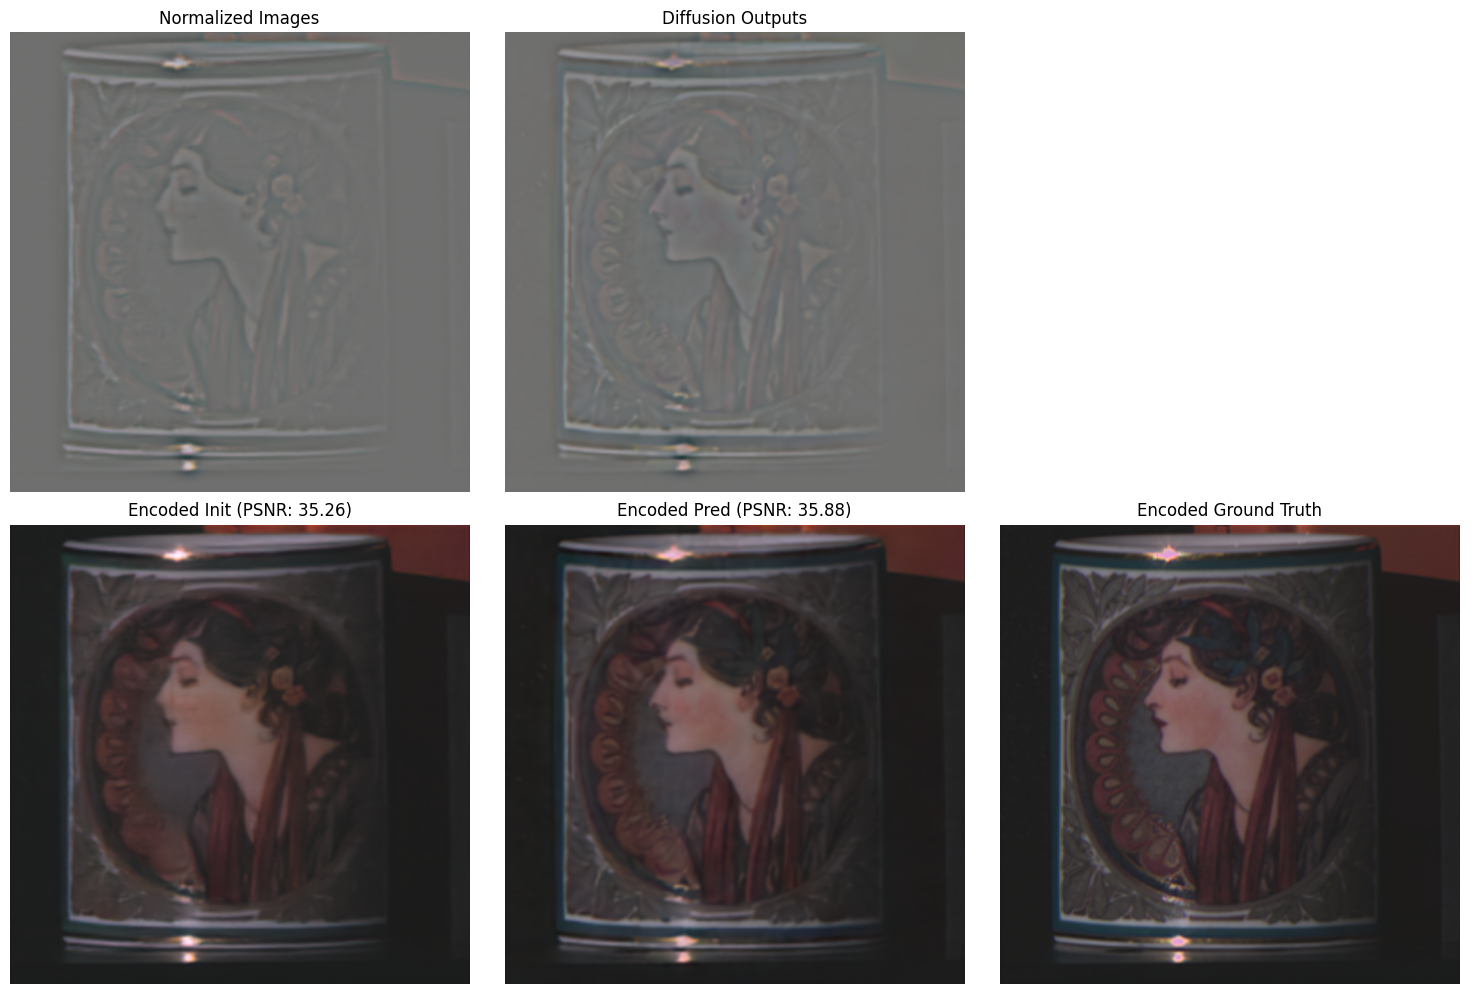

In [24]:
t = range(10)

@torch.no_grad()
def test():
    t_new = range(len(t))
    scenes = [sio.loadmat(f"./results/{str(t[i])}.mat") for i in t_new]

    pred = torch.tensor([scenes[i]["pred"] for i in t_new])
    init = torch.tensor([scenes[i]["init"] for i in t_new])
    test_data = torch.tensor([scenes[i]["truth"] for i in t_new])
    diffusion_outputs = torch.tensor([scenes[i]["diffusion_outputs"] for i in t_new])
    normalized_images = torch.tensor([scenes[i]["normalized_images"] for i in t_new])

    # Calculate metrics for both pred and init
    def calculate_metrics(data, reference, name):
        psnr_list = []
        ssim_list = []
        for i in range(reference.shape[0]):
            psnr = torch_psnr(data[i], reference[i])
            ssim = torch_ssim(data[i], reference[i])
            psnr_list.append(psnr)
            ssim_list.append(ssim)
        return psnr_list, ssim_list

    init_psnr_list, init_ssim_list = calculate_metrics(init, test_data, "Init")
    pred_psnr_list, pred_ssim_list = calculate_metrics(pred, test_data, "Pred")
    
    # Compute deltas per image
    delta_psnr_list = [pred_psnr_list[i] - init_psnr_list[i] for i in range(len(pred_psnr_list))]
    delta_ssim_list = [pred_ssim_list[i] - init_ssim_list[i] for i in range(len(pred_ssim_list))]
    
    # Print per image with four columns: PSNR, SSIM, Delta PSNR, Delta SSIM
    for i in range(len(pred_psnr_list)):
        print(f"For image {i+1}  PSNR: {pred_psnr_list[i]:.2f}   SSIM: {pred_ssim_list[i]:.4f}   Delta PSNR: {delta_psnr_list[i]:.2f}   Delta SSIM: {delta_ssim_list[i]:.4f}")
    
    # Compute and print averages
    avg_pred_psnr = sum(pred_psnr_list) / len(pred_psnr_list)
    avg_pred_ssim = sum(pred_ssim_list) / len(pred_ssim_list)
    avg_delta_psnr = sum(delta_psnr_list) / len(delta_psnr_list)
    avg_delta_ssim = sum(delta_ssim_list) / len(delta_ssim_list)
    
    print(f"\nAverage PSNR for all images: {avg_pred_psnr:.2f}")
    print(f"Average SSIM for all images: {avg_pred_ssim:.4f}")
    print(f"Average Delta PSNR for all images: {avg_delta_psnr:.2f}")
    print(f"Average Delta SSIM for all images: {avg_delta_ssim:.4f}")

    # Create subplot visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # First row: RGB visualizations
    axes[0, 0].imshow(normalized_images[0].permute(1, 2, 0).detach().cpu().numpy())
    axes[0, 0].set_title("Normalized Images")
    axes[0, 0].axis("off")
    
    axes[0, 1].imshow(diffusion_outputs[0].permute(1, 2, 0).detach().cpu().numpy())
    axes[0, 1].set_title("Diffusion Outputs")
    axes[0, 1].axis("off")
    
    axes[0, 2].axis("off")  # Empty subplot
    
    # Second row: Encoded visualizations
    encoded_init = np.clip(PSRSCI_Pipeline.encoder(init.cuda())[0].permute(1, 2, 0).detach().cpu().numpy() + 0.1, 0, 1)
    encoded_pred = np.clip(PSRSCI_Pipeline.encoder(pred.cuda())[0].permute(1, 2, 0).detach().cpu().numpy() + 0.1, 0, 1)
    encoded_gt = np.clip(PSRSCI_Pipeline.encoder(test_data.cuda())[0].permute(1, 2, 0).detach().cpu().numpy() + 0.1, 0, 1)
    
    axes[1, 0].imshow(encoded_init)
    axes[1, 0].set_title(f"Encoded Init (PSNR: {sum(init_psnr_list)/len(init_psnr_list):.2f})")
    axes[1, 0].axis("off")
    
    axes[1, 1].imshow(encoded_pred)
    axes[1, 1].set_title(f"Encoded Pred (PSNR: {avg_pred_psnr:.2f})")
    axes[1, 1].axis("off")
    
    axes[1, 2].imshow(encoded_gt)
    axes[1, 2].set_title("Encoded Ground Truth")
    axes[1, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

test()

-------

# Extra a. Performance of SeVAE on simulation data

In [25]:
import time
import torch
from packages.MST.simulation.train_code.utils import *

test_data = LoadTest(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/Truth/")
test_data = test_data.cuda().float()

mask3d_batch, input_mask = init_mask(str(BASE_DIR)+"/packages/MST/datasets/TSA_simu_data/", "Phi", 10)
input_meas = init_meas(test_data, mask3d_batch, "H").cuda()

total_psnr = 0.0
total_ssim = 0.0

with torch.no_grad():
    hf, lf = wavelet_decomposition_msi(test_data, 3)
    pred = SeVAE_model(hf) + lf

for i in range(test_data.shape[0]):
    current_psnr = torch_psnr(pred[i], test_data[i])
    current_ssim = torch_ssim(pred[i], test_data[i])

    total_psnr += current_psnr
    total_ssim += current_ssim

    print(f"For image {i+1}  PSNR: {current_psnr:.2f}   SSIM: {current_ssim:.4f}")

average_psnr = total_psnr / test_data.shape[0]
average_ssim = total_ssim / test_data.shape[0]

print(f"\nAverage PSNR for all images: {average_psnr:.2f}")
print(f"Average SSIM for all images: {average_ssim:.4f}")

# Speed measurement: Run the core computation 100 times and average the time
num_runs = 100

times = []
hf, lf = wavelet_decomposition_msi(test_data[:1], 3)

with torch.no_grad():
    start_time = time.perf_counter()
    for _ in range(num_runs):
        _ = SeVAE_model(hf)  # Process only the first image for speed test
    end_time = time.perf_counter()

average_time = (end_time - start_time) / num_runs
print(f"Average time for 100 runs: {average_time:.6f} seconds")

For image 1  PSNR: 48.71   SSIM: 0.9972
For image 2  PSNR: 51.14   SSIM: 0.9969
For image 3  PSNR: 48.35   SSIM: 0.9920
For image 4  PSNR: 56.09   SSIM: 0.9990
For image 5  PSNR: 47.47   SSIM: 0.9974
For image 6  PSNR: 48.58   SSIM: 0.9974
For image 7  PSNR: 46.50   SSIM: 0.9925
For image 8  PSNR: 47.05   SSIM: 0.9949
For image 9  PSNR: 48.78   SSIM: 0.9952
For image 10  PSNR: 49.85   SSIM: 0.9982

Average PSNR for all images: 49.25
Average SSIM for all images: 0.9961
Average time for 100 runs: 0.120225 seconds
